In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df = pd.read_csv('NFL_pbp_2009-2019.csv', low_memory=False)

threshold = 100000
df['field_goal_result'].fillna('none', inplace=True)
dfV2 = df.loc[:, df.isnull().sum() < threshold]
missing_values = dfV2.isnull().sum()

statistical_cols = ['play_id', 'game_id', 'home_team', 'away_team', 'posteam', 
                    'defteam', 'side_of_field', 'yardline_100', 'half_seconds_remaining', 
                    'game_seconds_remaining', 'game_half', 'drive', 'qtr', 'down', 'goal_to_go', 'time', 
                    'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'home_timeouts_remaining', 
                    'away_timeouts_remaining', 'total_home_score',  'total_away_score', 'score_differential', 'home_wp', 'away_wp', 'ep']

game_dynamics_cols = [
    'punt_blocked', 'first_down_rush', 'first_down_pass', 'first_down_penalty', 'third_down_converted',
    'third_down_failed', 'fourth_down_converted', 'fourth_down_failed', 'incomplete_pass', 'interception',
    'fumble_forced', 'fumble_not_forced', 'fumble_out_of_bounds', 'solo_tackle', 'safety', 'penalty',
    'tackled_for_loss', 'fumble_lost', 'own_kickoff_recovery', 'own_kickoff_recovery_td', 'qb_hit',
    'rush_attempt', 'pass_attempt', 'sack', 'touchdown', 'pass_touchdown', 'rush_touchdown', 'field_goal_result',
    'return_touchdown', 'extra_point_attempt', 'two_point_attempt', 'field_goal_attempt', 'kickoff_attempt',
    'punt_attempt', 'fumble', 'complete_pass', 'shotgun', 'no_huddle', 'punt_inside_twenty', 'kickoff_inside_twenty']

columns_to_keep = statistical_cols + game_dynamics_cols
dfV3 = dfV2[columns_to_keep]

dfV4 = dfV3.drop(['play_id', 'game_seconds_remaining', 'fumble_forced'], axis=1)
dfV4 = dfV4.dropna(subset=['down', 'defteam', 'posteam'])
dfV4 = dfV4.reset_index(drop=True)

# Indicators for if within last 2 minutes of the half and the whole game
dfV4['close_to_end_of_half'] = (dfV4['half_seconds_remaining'] <= 120).astype(int)
dfV4['close_to_end_of_game'] = ((dfV4['half_seconds_remaining'] <= 120) & (dfV4['game_half'] == 'Half2')).astype(int)

# Indicator for if the touchdown was for the away or home team
dfV4['home_td'] = ((dfV4['touchdown'] == 1) & (dfV4['posteam'] != dfV4['away_team'])).astype(int)
dfV4['away_td'] = ((dfV4['touchdown'] == 1) & (dfV4['posteam'] != dfV4['home_team'])).astype(int)

# Trackers for the difference in both teams' win probability after each play
dfV4['home_wp_change'] = dfV4['home_wp'].diff().fillna(0)
dfV4['away_wp_change'] = dfV4['away_wp'].diff().fillna(0)

# Indicator for turnover
dfV4['turnover'] = (
    (dfV4['safety'] == 1) |
    (dfV4['interception'] == 1) |
    (dfV4['fumble_lost'] == 1) |
    ((dfV4['fourth_down_converted'] == 0) & (dfV4['down'] == 4))
).astype(int)

# Drive time - Added drive ended indicator to help - Manually resets after end of game, half, and change of possession
dfV4['drive_ended'] = (
    (dfV4['posteam'] != dfV4['posteam'].shift(1)) |  
    (dfV4['game_id'] != dfV4['game_id'].shift(1)) |  
    dfV4['desc'].str.contains('END GAME', na=False) |  
    dfV4['desc'].str.contains('END QUARTER', na=False)  
).astype(int)
dfV4['drive'] = (
    (dfV4['posteam'].ne(dfV4['posteam'].shift())) |
    (dfV4['game_id'].ne(dfV4['game_id'].shift()))
).cumsum()
dfV4['drive_time_seconds'] = (
    dfV4.groupby(['game_id', 'drive'])['half_seconds_remaining']
    .transform('first') - dfV4['half_seconds_remaining']
)
dfV4['drive_time_seconds'] = dfV4.apply(
    lambda row: 0 if row['drive_ended'] == 1 else row['drive_time_seconds'], axis=1
)
dfV4['drive_time_seconds'] = dfV4.groupby(['game_id', 'drive'])['drive_time_seconds'].cumsum()

# Indicator for long touchdowns
dfV4['long_td'] = ((dfV4['touchdown'] == 1) & (dfV4['yards_gained'] >= 50)).astype(int)

# Trackers for score differentials and lead changes
dfV4['home_score_differential'] = dfV4['total_home_score'] - dfV4['total_away_score']
dfV4['away_score_differential'] = -dfV4['home_score_differential']
dfV4['lead_change'] = ((dfV4['home_score_differential'].diff() < 0) &
                       (dfV4['home_score_differential'].shift() * dfV4['home_score_differential'] < 0)).astype(int)

# Combining first down indicators
dfV4['first_down'] = ((dfV4['first_down_pass'] == 1) | (dfV4['first_down_rush'] == 1) | (dfV4['first_down_penalty'] == 1)).astype(int)

# Indicators for scoring drives - Removing
dfV4['home_scoring_drive'] = (
    (dfV4['home_td'] == 1) 
).astype(int)
dfV4['away_scoring_drive'] = (
    (dfV4['away_td'] == 1) 
).astype(int)

# Helper for consecutive scoring events - Remove Later!!!!!!!!!!!!!!
dfV4['home_scoring_events'] = (
    (dfV4['posteam'] != dfV4['away_team']) & 
    ((dfV4['home_td'] == 1) | (dfV4['field_goal_result'] == 'made'))
).astype(int)
dfV4['away_scoring_events'] = (
    (dfV4['posteam'] != dfV4['home_team']) & 
    ((dfV4['away_td'] == 1) | (dfV4['field_goal_result'] == 'made'))
).astype(int)

# Consecutive Scoring Events + Helper function 
def calc_consecutive_cumsum_with_game_reset(series, reset_series, game_ids):
    cumsum = 0
    consecutive = []
    prev_game_id = None  
    
    for i in range(len(series)):
        if game_ids[i] != prev_game_id:
            cumsum = 0 
        if reset_series[i] == 1:  
            cumsum = 0
        if series[i] == 1:  
            cumsum += 1
        consecutive.append(cumsum)
        prev_game_id = game_ids[i]  
    return consecutive

dfV4['home_csum_scores'] = calc_consecutive_cumsum_with_game_reset(
    dfV4['home_scoring_events'], dfV4['away_scoring_events'], dfV4['game_id']
)
dfV4['away_csum_scores'] = calc_consecutive_cumsum_with_game_reset(
    dfV4['away_scoring_events'], dfV4['home_scoring_events'], dfV4['game_id']
)

#Consecutive defensive stops
dfV4['home_def_stop'] = (
    (dfV4['posteam'] != dfV4['home_team']) &  ((dfV4['punt_attempt'] == 1) |  (dfV4['turnover'] == 1)) & 
    ~dfV4['field_goal_result'].isin(['made'])  
).astype(int)
dfV4['away_def_stop'] = (
    (dfV4['posteam'] != dfV4['away_team']) & ((dfV4['punt_attempt'] == 1) |  (dfV4['turnover'] == 1)) & 
    ~dfV4['field_goal_result'].isin(['made'])
).astype(int)

def calc_consecutive_defensive_stops_with_game_reset(series, reset_series, game_ids):
    cumsum = 0
    consecutive = []
    prev_game_id = None  
    for i in range(len(series)):
        if game_ids[i] != prev_game_id:
            cumsum = 0
        if reset_series[i] == 1:
            cumsum = 0
        if series[i] == 1:
            cumsum += 1
        consecutive.append(cumsum)
        prev_game_id = game_ids[i]  
    return consecutive

dfV4['home_csum_def_stops'] = calc_consecutive_defensive_stops_with_game_reset(
    dfV4['home_def_stop'], dfV4['away_scoring_events'], dfV4['game_id']
)
dfV4['away_csum_def_stops'] = calc_consecutive_defensive_stops_with_game_reset(
    dfV4['away_def_stop'], dfV4['home_scoring_events'], dfV4['game_id']
)

# Home/Away Drive Numbers
dfV4['away_drive_number'] = (
    dfV4.loc[dfV4['posteam'] != dfV4['home_team']]
    .groupby('game_id')['drive_ended'].cumsum()
)
dfV4['home_drive_number'] = (
    dfV4.loc[dfV4['posteam'] == dfV4['home_team']]
    .groupby('game_id')['drive_ended'].cumsum()
)

# Offense needs to score
dfV4['off_need_score'] = (
    (dfV4['down'].isin([3, 4])) & 
    (abs(dfV4['score_differential']) <= 8) & 
    (dfV4['qtr'] >= 4) &
    (dfV4['first_down'] == 1)
).astype(int)

# Defense Needs a Stop
dfV4['def_need_stop'] = (
    (dfV4['down'].isin([3, 4])) & 
    (abs(dfV4['score_differential']) <= 8) & 
    (dfV4['qtr'] >= 4) &
    (dfV4['turnover'] == 1)
).astype(int)

# Drought Ending score
dfV4['drought_end_play'] = (
    ((dfV4['away_csum_scores'].shift(1) >= 2) & (dfV4['away_csum_scores'] == 0) & (dfV4['home_scoring_events'] == 1)) |
    ((dfV4['home_csum_scores'].shift(1) >= 2) & (dfV4['home_csum_scores'] == 0) & (dfV4['away_scoring_events'] == 1))
).astype(int)

# Defensive touchdown
dfV4['def_td'] = (
    ((dfV4['fumble'] == 1) & (dfV4['return_touchdown'] == 1)) |
    ((dfV4['interception'] == 1) & (dfV4['return_touchdown'] == 1))
).astype(int)

# Defensive touchdown
dfV4['off_td'] = (
    (dfV4['pass_touchdown'] == 1) | (dfV4['rush_touchdown'] == 1)
).astype(int)

# Special Teams touchdown
dfV4['st_return_td'] = (
    ((dfV4['kickoff_attempt'] == 1) & (dfV4['return_touchdown'] == 1)) | 
    ((dfV4['punt_attempt'] == 1) & (dfV4['return_touchdown'] == 1))  
).astype(int)

# Big special teams play...punt blocked, field goal blocked, return_touchdown, kick recovery, pin team near endzone
dfV4['big_st_play'] = (
    (dfV4['punt_blocked'] == 1) | 
    (dfV4['field_goal_result'] == 'blocked') | 
    (dfV4['own_kickoff_recovery'] == 1) | 
    (dfV4['st_return_td'] == 1) | 
    (dfV4['kickoff_inside_twenty'] == 1) | 
    (dfV4['punt_inside_twenty'] == 1)
).astype(int)

# Scoring type differentiatior, touchdowns should hold more weight than a field goal, other types may hold more weight also
dfV4['scoring_type'] = np.select(
    [
        dfV4['field_goal_result'] == 'made',
        dfV4['off_td'] == 1,
        dfV4['def_td'] == 1,
        dfV4['st_return_td'] == 1,
    ],
    ['fg', 'off_td', 'def_td', 'st_td'],
    default='none'
)

# Indicator for big offensive play
dfV4['big_offensive_play'] = (
        (dfV4['yards_gained'] >= 40) |
        (dfV4['long_td'] == 1) |
        ((dfV4['off_need_score'] == 1) & (dfV4['off_td'] == 1))
).astype(int)

# Indicator for big defensive play
dfV4['big_defensive_play'] = (
    (dfV4['sack'] == 1) |
    (dfV4['tackled_for_loss'] == 1) |
    ((dfV4['def_need_stop'] == 1) & ((dfV4['def_td'] == 'def_td')) | dfV4['turnover'] == 1) |
    (dfV4['scoring_type'] == 'def_td')
).astype(int)

#Quick Score and Quick Stop #### Needs fixing, only want 1 on last play of drive when they score or get stop, right now 1 for whole drive
dfV4['total_drive_time'] = dfV4.groupby('drive')['drive_time_seconds'].transform('last') 

dfV4['quick_score'] = (
    (dfV4['drive_time_seconds'] < 180) &
    ((dfV4['touchdown'] == 1) | (dfV4['field_goal_result'] == 'made')) &
    (dfV4.groupby('drive')['drive_time_seconds'].transform('last') == dfV4['drive_time_seconds'])
).astype(int)
dfV4['quick_stop'] = (
    (dfV4['total_drive_time'] < 180) & 
    (dfV4['scoring_type'] == 'none') &
    (dfV4.groupby('drive')['drive_time_seconds'].transform('last') == dfV4['drive_time_seconds'])
).astype(int)

# Consecutive first downs
dfV4['home_csum_first_downs'] = 0
dfV4['away_csum_first_downs'] = 0
dfV4['home_csum_first_downs'] = (
    dfV4.groupby(['home_team', 'away_team', 'home_drive_number'])['first_down']
    .cumsum()
    .where(dfV4['posteam'] != 'away_team', 0)
)
dfV4['away_csum_first_downs'] = (
    dfV4.groupby(['home_team', 'away_team', 'away_drive_number'])['first_down']
    .cumsum()
    .where(dfV4['posteam'] != 'home_team', 0)
)


columns_to_remove = [
    'ep', 'punt_blocked', 'first_down_rush', 'first_down_pass', 
    'third_down_converted', 'third_down_failed', 'fourth_down_converted', 
    'fourth_down_failed', 'incomplete_pass', 'interception', 'fumble_not_forced', 
    'fumble_out_of_bounds', 'solo_tackle', 'safety', 'penalty', 'tackled_for_loss', 
    'fumble_lost', 'own_kickoff_recovery', 'own_kickoff_recovery_td', 'qb_hit', 
    'rush_attempt', 'pass_attempt', 'sack', 'extra_point_attempt', 'two_point_attempt', 
    'field_goal_attempt', 'kickoff_attempt', 'punt_attempt', 'fumble', 'pass_touchdown', 'rush_touchdown'
    'complete_pass', 'shotgun', 'home_scoring_drive', 'away_scoring_drive','home_scoring_events','away_scoring_events',
    'rush_touchdown', 'field_goal_result', 'return_touchdown', 'complete_pass', 'no_huddle', 'punt_inside_twenty', 'kickoff_inside_twenty',
    'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'side_of_field', 'yardline_100', 'desc', 'drive', 'game_half', 'drive_ended', 'drive_time_seconds',
    'touchdown', 'score_differential', 'total_drive_time'
]

dfV5 = dfV4.drop(columns=columns_to_remove, errors='ignore')

dynamics = [
    ('big_offensive_play', dfV5['big_offensive_play'] == 1),
    ('big_defensive_play', dfV5['big_defensive_play'] == 1),
    ('off_td', dfV5['off_td'] == 1),
    ('def_td', dfV5['def_td'] == 1),
    ('big_st_play', dfV5['big_st_play'] == 1),
    ('st_return_td', dfV5['st_return_td'] == 1),
    ('off_need_score', dfV5['off_need_score'] == 1),
    ('def_need_stop', dfV5['def_need_stop'] == 1),
    ('drought_end_play', dfV5['drought_end_play'] == 1),
    ('home_csum_scores', dfV5['home_csum_scores'] >= 2),
    ('away_csum_scores', dfV5['away_csum_scores'] >= 2),
    ('home_csum_def_stops', dfV5['home_csum_def_stops'] >= 2),
    ('away_csum_def_stops', dfV5['away_csum_def_stops'] >= 2),
    ('home_csum_first_downs', dfV5['home_csum_first_downs'] >= 2),
    ('away_csum_first_downs', dfV5['away_csum_first_downs'] >= 2),
    ('long_td', dfV5['long_td'] == 1),
    ('quick_score', dfV5['quick_score'] == 1),
    ('quick_stop', dfV5['quick_stop'] == 1),
    ('home_score_differential', dfV5['home_score_differential'] == 1),
    ('away_score_differential', dfV5['away_score_differential'] == 1),
]



# Momentum Score - Multipliers, Base Values, Decay, and Calculations

In [61]:

def_wp_change = {
    "big_defensive_play": 0.029471,
    "def_td": 0.016322,
    "big_st_play": 0.034637,
    "st_return_td": 0.040082,
    "def_need_stop": 0.042132,
    "quick_stop": 0.029971
}

off_wp_change = {
    "big_offensive_play": 0.038602,
    "off_td": 0.028432,
    "off_need_score":  0.035536, 
    "drought_end_play": 0.028891,
    "long_td": 0.033325,
    "quick_score": 0.026664
}

streaks_multipliers = {
    "home_csum_scores": 1.26948,
    "away_csum_scores": 1.30347,
    "home_csum_first_downs": 1.27913,
    "away_csum_first_downs": 1.27763,
    "home_csum_def_stops": 1.28362,
    "away_csum_def_stops": 1.28139,
}

score_game_multipliers = {
    "tied_or_1_score": 1.1,
    "2_score": 1.07,
    "3_or_more_score": 1.05
}

qtr_multipliers = {
    "first_and_fourth": 1.1,
    "second_and_third": 1.0
}

home_away_multipliers = {
    "home": 1.2,  
    "away": 1.0   
}

boost_case_multipliers = {
    "home_and_4th": 1.4,  
    "away_and_1st": 1.4,  
    "none": 1.0           
}

decay_multipliers = {
    "opponent_scores": 0.5,
    "opponent_consecutive_stops": 0.8,
    "turnover": 0.5,
    "opponent_ends_drought": 0.8,
    "none": 0.0  
}


def calculate_multipliers(row, index, category, is_offensive):
    if abs(row['home_score_differential']) <= 8:
        S = score_game_multipliers["tied_or_1_score"]
    elif 9 <= abs(row['home_score_differential']) <= 16:
        S = score_game_multipliers["2_score"]
    else:
        S = score_game_multipliers["3_or_more_score"]

    team = row['posteam'] if is_offensive else row['defteam']
    HA = home_away_multipliers.get(team, 1.0)

    if row['qtr'] == 1 or row['qtr'] == 4:
        Q = qtr_multipliers["first_and_fourth"]
    else:
        Q = qtr_multipliers["second_and_third"]

    if is_offensive:
        if row['posteam'] == 'home' and row['qtr'] == 4:
            B = boost_case_multipliers["home_and_4th"]
        elif row['posteam'] == 'away' and row['qtr'] == 1:
            B = boost_case_multipliers["away_and_1st"]
        else:
            B = 1.0
    else:
        if team == 'home' and row['qtr'] == 4:
            B = boost_case_multipliers["home_and_4th"]
        elif team == 'away' and row['qtr'] == 1:
            B = boost_case_multipliers["away_and_1st"]
        else:
            B = 1.0

    CS = 1.0
   
    if is_offensive:
        if row['posteam'] == row['home_team']:
            if row['home_csum_scores'] >= 2:
                if row['home_csum_scores'] > dfV5.at[index - 1, 'home_csum_scores']: 
                    CS = streaks_multipliers['home_csum_scores']
            elif row['home_csum_first_downs'] >= 4:
                if row['home_csum_first_downs'] > dfV5.at[index - 1, 'home_csum_first_downs']: 
                    CS = streaks_multipliers['home_csum_first_downs']
            else:
                CS = 1.0
        else:
            if row['away_csum_scores'] >= 2:
                if row['away_csum_scores'] > dfV5.at[index - 1, 'away_csum_scores']: 
                    CS = streaks_multipliers['away_csum_scores']
            elif row['away_csum_first_downs'] >= 4:
                if row['away_csum_first_downs'] >  dfV5.at[index - 1, 'away_csum_first_downs']: 
                    CS = streaks_multipliers['away_csum_first_downs']
            else:
                CS = 1.0
    else:
        if row['defteam'] == row['home_team']:
            if row['home_csum_def_stops'] >= 2:
                if row['home_csum_def_stops'] > dfV5.at[index - 1, 'home_csum_def_stops']: 
                    CS = streaks_multipliers['home_csum_def_stops']
            else:
                CS = 1.0
        else:
            if row['away_csum_def_stops'] >= 2:
                if row['away_csum_def_stops'] > dfV5.at[index - 1, 'away_csum_def_stops']:
                    CS = streaks_multipliers['away_csum_def_stops']
            else:
                CS = 1.0

    return S, HA, B, CS, Q



def calculate_momentum_gain(wp_change_value, S, HA, CS, B, Q):
    return wp_change_value * (S * HA * CS * B * Q) * 1000




def calculate_decay(row, category, momentum_gain):
    if category in ['off_td', 'long_td', 'def_td', 'st_return_td']:
        D = decay_multipliers['opponent_scores']
    elif row['turnover'] == 1:
        D = decay_multipliers['turnover']
    elif row['drought_end_play'] == 1:
        D = decay_multipliers["opponent_ends_drought"]
    else:
        D = decay_multipliers['none']

    return momentum_gain * D



def update_momentum_scores(dfV5):
    dfV5['Home_Momentum_Score'] = 500
    dfV5['Away_Momentum_Score'] = 500

    dfV5['game_id_diff'] = dfV5['game_id'] != dfV5['game_id'].shift(1)

    for index, row in dfV5.iterrows():
        if index == 0:  
            continue

        if row['game_id_diff']:
            dfV5.at[index, 'Home_Momentum_Score'] = 500
            dfV5.at[index, 'Away_Momentum_Score'] = 500
            continue

        home_momentum_gain = 0
        away_momentum_gain = 0

        for category, wp_change_value in off_wp_change.items():
            if row[category] == 1:
                S, HA, B, CS, Q = calculate_multipliers(row, index, category, True)
                momentum_gain = calculate_momentum_gain(wp_change_value, S, HA, CS, B, Q)
                momentum_loss = calculate_decay(row, category, momentum_gain)

                if row['posteam'] == row['home_team']:
                    home_momentum_gain += momentum_gain
                    away_momentum_gain -= momentum_loss
                else:
                    away_momentum_gain += momentum_gain
                    home_momentum_gain -= momentum_loss

        for category, wp_change_value in def_wp_change.items():
            if row[category] == 1:
                S, HA, B, CS, Q = calculate_multipliers(row, index, category, False)
                momentum_gain = calculate_momentum_gain(wp_change_value, S, HA, CS, B, Q)
                momentum_loss = calculate_decay(row, category, momentum_gain)

                if row['defteam'] == row['home_team']:
                    home_momentum_gain += momentum_gain
                    away_momentum_gain -= momentum_loss
                else:
                    away_momentum_gain += momentum_gain
                    home_momentum_gain -= momentum_loss

        dfV5.at[index, 'Home_Momentum_Score'] = dfV5.at[index - 1, 'Home_Momentum_Score'] + home_momentum_gain
        dfV5.at[index, 'Away_Momentum_Score'] = dfV5.at[index - 1, 'Away_Momentum_Score'] + away_momentum_gain

update_momentum_scores(dfV5)

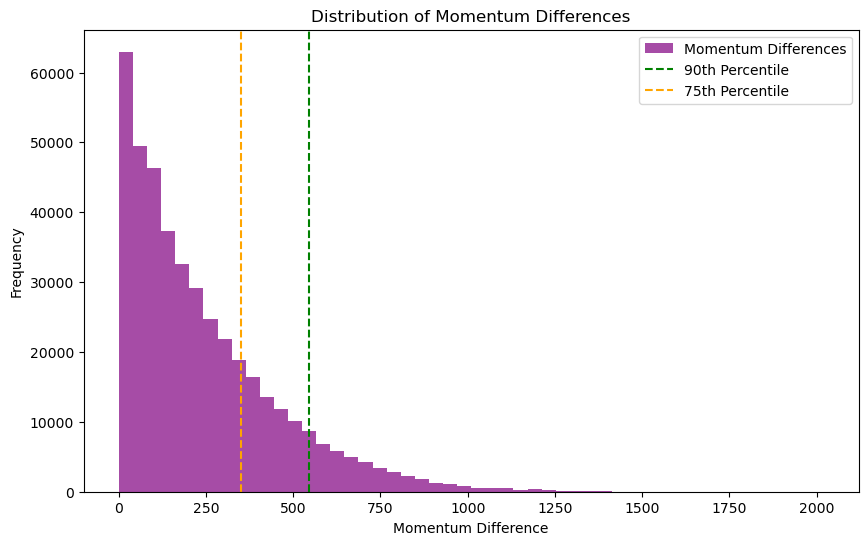

75th Percentile Difference: 348.93749276028973
90th Percentile Difference: 546.4160584619799


In [66]:
def analyze_momentum_differences(dfV5):
    dfV5['Momentum_Difference'] = abs(dfV5['Home_Momentum_Score'] - dfV5['Away_Momentum_Score'])
    
    plt.figure(figsize=(10, 6))
    plt.hist(dfV5['Momentum_Difference'], bins=50, color='purple', alpha=0.7, label='Momentum Differences')
    plt.axvline(np.percentile(dfV5['Momentum_Difference'], 90), color='green', linestyle='--', label='90th Percentile')
    plt.axvline(np.percentile(dfV5['Momentum_Difference'], 75), color='orange', linestyle='--', label='75th Percentile')
    plt.title('Distribution of Momentum Differences')
    plt.xlabel('Momentum Difference')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    return np.percentile(dfV5['Momentum_Difference'], [75, 90])

# Usage
percentiles = analyze_momentum_differences(dfV5)
print(f"75th Percentile Difference: {percentiles[0]}")
print(f"90th Percentile Difference: {percentiles[1]}")

# Checking correct teams gaining/losing momentum

In [ ]:
offensive_columns = ['home_team', 'away_team', 'posteam', 'big_offensive_play', 'off_td', 'Home_Momentum_Score', 'Away_Momentum_Score']

big_play_indices = dfV5[dfV5['big_offensive_play'] == 1].index
previous_and_current_indices = big_play_indices.union(big_play_indices - 1)
filtered_df = dfV5.loc[previous_and_current_indices, offensive_columns]
filtered_df.sort_index().head(100)

In [ ]:

defensive_columns = ['defteam', 'home_team', 'away_team', 'big_defensive_play', 'def_td', 'Home_Momentum_Score', 'Away_Momentum_Score']
big_play_indices = dfV5[dfV5['big_defensive_play'] == 1].index
previous_and_current_indices = big_play_indices.union(big_play_indices - 1)
filtered_df = dfV5.loc[previous_and_current_indices, defensive_columns]
filtered_df.sort_index().head(100)

# Summary of Momentum Scores

## Refinements/Changes Made:
### Quarter multiplier added (thought i had this the whole time but was missing)
### Changed multipliers from 0.? to 1.?... This made a lot more sense to actually work as a multiplier on the base percent values and helped make the scale factor much smaller (1000 from 1000000)
### Streaks moved from Base Value to Multiplier, made sense for the logic of only triggering if the streak is 2 or more and gains 1
### Fixed logic for streaks, and time-based events (quick score, quick stop)
### Lowered decay factors slightly in same ratio to take less momentum away, scores reached negative before

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Home Momentum Score Summary:")
print(dfV5['Home_Momentum_Score'].describe())

print("\nAway Momentum Score Summary:")
print(dfV5['Away_Momentum_Score'].describe())

#Line Chart for Trends
plt.figure(figsize=(12, 6))
plt.plot(dfV5.index, dfV5['Home_Momentum_Score'], label='Home Momentum', color='blue')
plt.plot(dfV5.index, dfV5['Away_Momentum_Score'], label='Away Momentum', color='red')
plt.title('Home vs Away Momentum Scores Over Time')
plt.xlabel('Plays')
plt.ylabel('Momentum Score')
plt.legend()
plt.grid()
plt.show()

#Histogram for distribution
plt.figure(figsize=(12, 6))
sns.histplot(dfV5['Home_Momentum_Score'], bins=30, kde=True, color='blue', label='Home Momentum')
sns.histplot(dfV5['Away_Momentum_Score'], bins=30, kde=True, color='red', label='Away Momentum')
plt.title('Distribution of Momentum Scores')
plt.xlabel('Momentum Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Box plot for outliers and visual spread
plt.figure(figsize=(8, 6))
sns.boxplot(data=dfV5[['Home_Momentum_Score', 'Away_Momentum_Score']])
plt.title('Home and Away Momentum Score Distribution')
plt.ylabel('Momentum Score')
plt.show()

# Max and Min Momentum Gain + Loss
## Logically seems in a good spot, largest gain and loss for Home and Away coincide with same games, in the 4th quarter, and follow the foundation of the momentum score calculation trends (Change in Win Probability)

In [ ]:
momentum_columns = ['game_id', 'home_team', 'away_team', 'posteam', 'defteam', 
                    'Home_Momentum_Score', 'Away_Momentum_Score']

dfV5['Home_Momentum_Change'] = dfV5.groupby('game_id')['Home_Momentum_Score'].diff()
dfV5['Away_Momentum_Change'] = dfV5.groupby('game_id')['Away_Momentum_Score'].diff()

def get_max_min_indices(group, column):
    max_idx = group[column].idxmax()
    min_idx = group[column].idxmin()
    return [max_idx, min_idx]

home_indices = dfV5.groupby('game_id').apply(lambda g: get_max_min_indices(g, 'Home_Momentum_Change')).explode().astype(int)
away_indices = dfV5.groupby('game_id').apply(lambda g: get_max_min_indices(g, 'Away_Momentum_Change')).explode().astype(int)
all_indices = sorted(set(home_indices.tolist() + away_indices.tolist()))
biggest_gains_losses = dfV5.loc[all_indices, momentum_columns + ['Home_Momentum_Change', 'Away_Momentum_Change']]

max_home = biggest_gains_losses.loc[biggest_gains_losses['Home_Momentum_Change'].idxmax()]
min_home = biggest_gains_losses.loc[biggest_gains_losses['Home_Momentum_Change'].idxmin()]
max_away = biggest_gains_losses.loc[biggest_gains_losses['Away_Momentum_Change'].idxmax()]
min_away = biggest_gains_losses.loc[biggest_gains_losses['Away_Momentum_Change'].idxmin()]

print("Max Home Momentum Gain:")
print(max_home[momentum_columns + ['Home_Momentum_Change', 'Away_Momentum_Change']])

print("\nMin Home Momentum Loss:")
print(min_home[momentum_columns + ['Home_Momentum_Change', 'Away_Momentum_Change']])

print("\nMax Away Momentum Gain:")
print(max_away[momentum_columns + ['Home_Momentum_Change', 'Away_Momentum_Change']])

print("\nMin Away Momentum Loss:")
print(min_away[momentum_columns + ['Home_Momentum_Change', 'Away_Momentum_Change']])

num_surrounding_rows = 1

indices_to_check = [
    max_home.name, min_home.name, max_away.name, min_away.name
]

surrounding_rows = []

for idx in indices_to_check:
    start_idx = max(0, idx - num_surrounding_rows)  
    end_idx = idx + num_surrounding_rows + 1  
    surrounding_rows.append(dfV5.iloc[start_idx:end_idx])

surrounding_df = pd.concat(surrounding_rows)
surrounding_df.head(6)

# Different Game Outcome Scenarios - Blowout, close game, low scoring, high scoring, and over 5 lead changes
## Most of the time when a team gains momentum the other team loses momentum, but not always which is what i wanted or i would have just used a % and have them relative to eachother. Reason for this is feel like having relative percent for momentum score would oversimplify the momentum score and lead to less insights on the game flow and shifts

In [ ]:
final_game_rows = dfV5.groupby('game_id').tail(1)

final_game_rows['Total_Score'] = final_game_rows['total_home_score'] + final_game_rows['total_away_score']
final_game_rows['Margin_Of_Victory'] = abs(final_game_rows['total_home_score'] - final_game_rows['total_away_score'])

low_scoring_threshold = 20  
high_scoring_threshold = 60  
blowout_threshold = 30  

low_scoring_games = final_game_rows[final_game_rows['Total_Score'] < low_scoring_threshold]
high_scoring_games = final_game_rows[final_game_rows['Total_Score'] > high_scoring_threshold]
blowout_games = final_game_rows[final_game_rows['Margin_Of_Victory'] > blowout_threshold]
close_games = final_game_rows[(final_game_rows['Margin_Of_Victory'] <= 3) & (final_game_rows['Total_Score'] > 40)]

lead_changes_count = dfV5[dfV5['lead_change'] == 1].groupby('game_id').size()
games_with_lead_changes = lead_changes_count[lead_changes_count >= 5].index
lead_change_games = final_game_rows[final_game_rows['game_id'].isin(games_with_lead_changes)]

print("Low Scoring Games (Total Score < 20):")
print(low_scoring_games[['game_id', 'home_team', 'away_team', 'Total_Score']].head())

print("\nHigh Scoring Games (Total Score > 60):")
print(high_scoring_games[['game_id', 'home_team', 'away_team', 'Total_Score']].head())

print("\nBlowout Games (Margin of Victory > 30):")
print(blowout_games[['game_id', 'home_team', 'away_team', 'Margin_Of_Victory']].head())

print("Close Games (Margin <= 3 and Total Score > 40):")
print(close_games[['game_id', 'home_team', 'away_team', 'Total_Score', 'Margin_Of_Victory']].head())

print("\nGames with at least 5 lead changes:")
print(lead_change_games[['game_id', 'home_team', 'away_team', 'Total_Score', 'Margin_Of_Victory']].head())

In [ ]:

low_scoring_game_id = 2019102007  
high_scoring_game_id = 2019090802  
blowout_game_id = 2019091505     
close_game_id = 2019090808
lead_change_game_id = 2009121700 

low_scoring_game = dfV5[dfV5['game_id'] == low_scoring_game_id]
high_scoring_game = dfV5[dfV5['game_id'] == high_scoring_game_id]
blowout_game = dfV5[dfV5['game_id'] == blowout_game_id]
close_game = dfV5[dfV5['game_id'] == close_game_id]
lead_change_game = dfV5[dfV5['game_id'] == lead_change_game_id]

def plot_momentum_scores(game_data, game_id, game_type, home_score, away_score, home_team, away_team):
    plt.figure(figsize=(10, 6))
    plt.plot(game_data['Home_Momentum_Score'], label='Home Momentum', color='blue')
    plt.plot(game_data['Away_Momentum_Score'], label='Away Momentum', color='red')
    
    if home_score > away_score:
        winner = home_team
        winner_color = 'blue'  
    elif away_score > home_score:
        winner = away_team
        winner_color = 'red'   
    else:
        winner = "Draw"
        winner_color = 'gray'  
    
    plt.title(f'{game_type} Game Momentum Scores (Game ID: {game_id})')
    plt.xlabel('Play Index')
    plt.ylabel('Momentum Score')
    plt.legend()

    plt.text(0.5, 0.95, f'Winner: {winner}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12, color=winner_color)
    plt.grid(True)
    plt.show()

final_game_rows = dfV5.groupby('game_id').tail(1)
plot_momentum_scores(low_scoring_game, low_scoring_game_id, 'Low Scoring',
                     final_game_rows.loc[final_game_rows['game_id'] == low_scoring_game_id, 'total_home_score'].iloc[0],
                     final_game_rows.loc[final_game_rows['game_id'] == low_scoring_game_id, 'total_away_score'].iloc[0],
                     low_scoring_game['home_team'].iloc[0], low_scoring_game['away_team'].iloc[0])

plot_momentum_scores(high_scoring_game, high_scoring_game_id, 'High Scoring',
                     final_game_rows.loc[final_game_rows['game_id'] == high_scoring_game_id, 'total_home_score'].iloc[0],
                     final_game_rows.loc[final_game_rows['game_id'] == high_scoring_game_id, 'total_away_score'].iloc[0],
                     high_scoring_game['home_team'].iloc[0], high_scoring_game['away_team'].iloc[0])

plot_momentum_scores(blowout_game, blowout_game_id, 'Blowout',
                     final_game_rows.loc[final_game_rows['game_id'] == blowout_game_id, 'total_home_score'].iloc[0],
                     final_game_rows.loc[final_game_rows['game_id'] == blowout_game_id, 'total_away_score'].iloc[0],
                     blowout_game['home_team'].iloc[0], blowout_game['away_team'].iloc[0])

plot_momentum_scores(close_game, close_game_id, 'Close Game',
                     final_game_rows.loc[final_game_rows['game_id'] == close_game_id, 'total_home_score'].iloc[0],
                     final_game_rows.loc[final_game_rows['game_id'] == close_game_id, 'total_away_score'].iloc[0],
                     close_game['home_team'].iloc[0], close_game['away_team'].iloc[0])

plot_momentum_scores(lead_change_game, lead_change_game_id, 'Lead Change Game',
                     final_game_rows.loc[final_game_rows['game_id'] == lead_change_game_id, 'total_home_score'].iloc[0],
                     final_game_rows.loc[final_game_rows['game_id'] == lead_change_game_id, 'total_away_score'].iloc[0],
                     lead_change_game['home_team'].iloc[0], lead_change_game['away_team'].iloc[0])

# Momentum_Holding_Team: Starts at None, if changes then that is the indicator a momentum shift happened... Momentum_Shift_Occured True or False
## I like the numbers and how its looking off basic looks, i need to summarize the shifts and investigate them more/visualize, like adding indicators to the same graphs above, finding weird results, looking at outcome after momentum shifts, etc
## Fixed Potential Problem: When game is close and both teams gaining momentum, only trigger momentum shift if the opposite team has gained less than half the momentum threshold (125)... Seems sufficient but wondering if we could make the logic better, low scoring and close scoring game might want to trigger atleast one more momentum shift. One example is team gaining much more momentum score but not passing the other teams momentum score, while the other teams momentum hasnt gained very much/stalled out

In [178]:
dfV5['Game_Momentum_Diff'] = abs(dfV5['Home_Momentum_Score'] - dfV5['Away_Momentum_Score'])
dfV5['Game_Threshold'] = dfV5.groupby('game_id')['Game_Momentum_Diff'].transform('max') * 0.5

def detect_momentum_shifts(game_data):
    momentum_holding_team = None
    last_shift_home_momentum = game_data.iloc[0]['Home_Momentum_Score']
    last_shift_away_momentum = game_data.iloc[0]['Away_Momentum_Score']
    
    for i in range(1, len(game_data)): 
        home_momentum_diff = game_data.iloc[i]['Home_Momentum_Score'] - last_shift_home_momentum
        away_momentum_diff = game_data.iloc[i]['Away_Momentum_Score'] - last_shift_away_momentum        
        game_threshold = game_data.iloc[i]['Game_Threshold']

        home_momentum_shift = False
        away_momentum_shift = False

        if home_momentum_diff >= game_threshold and away_momentum_diff < game_threshold * .5:
            home_momentum_shift = True
        elif away_momentum_diff >= game_threshold and home_momentum_diff < game_threshold * .5:
            away_momentum_shift = True

        if home_momentum_shift:
            momentum_holding_team = "Home"
            last_shift_home_momentum = game_data.iloc[i]['Home_Momentum_Score']
            last_shift_away_momentum = game_data.iloc[i]['Away_Momentum_Score']
        elif away_momentum_shift:
            momentum_holding_team = "Away"
            last_shift_home_momentum = game_data.iloc[i]['Home_Momentum_Score']
            last_shift_away_momentum = game_data.iloc[i]['Away_Momentum_Score']

        game_data.iloc[i, game_data.columns.get_loc('Momentum_Holding_Team')] = momentum_holding_team

    return game_data

dfV5 = dfV5.groupby('game_id', group_keys=False).apply(detect_momentum_shifts)

dfV5['Momentum_Shift_Occurred'] = dfV5.groupby('game_id')['Momentum_Holding_Team'].transform(
    lambda x: x.ne(x.shift()) & x.notna()
)


In [156]:
dfV5[['game_id', 'home_team', 'away_team', 'Home_Momentum_Score', 'Away_Momentum_Score', 'Momentum_Holding_Team', 'Momentum_Shift_Occurred', 'Game_Threshold']].head(200)

,game_id,home_team,away_team,Home_Momentum_Score,Away_Momentum_Score,Momentum_Holding_Team,Momentum_Shift_Occurred,Game_Threshold
0,2019090500,CHI,GB,500.000000,500.000000,None,False,114.064610
1,2019090500,CHI,GB,500.000000,500.000000,None,False,114.064610
2,2019090500,CHI,GB,535.659910,500.000000,None,False,114.064610
3,2019090500,CHI,GB,571.319820,482.170045,None,False,114.064610
4,2019090500,CHI,GB,571.319820,482.170045,None,False,114.064610
5,2019090500,CHI,GB,571.319820,482.170045,None,False,114.064610
6,2019090500,CHI,GB,571.319820,482.170045,None,False,114.064610
7,2019090500,CHI,GB,571.319820,482.170045,None,False,114.064610
8,2019090500,CHI,GB,571.319820,482.170045,None,False,114.064610
9,2019090500,CHI,GB,571.319820,482.170045,None,False,114.064610


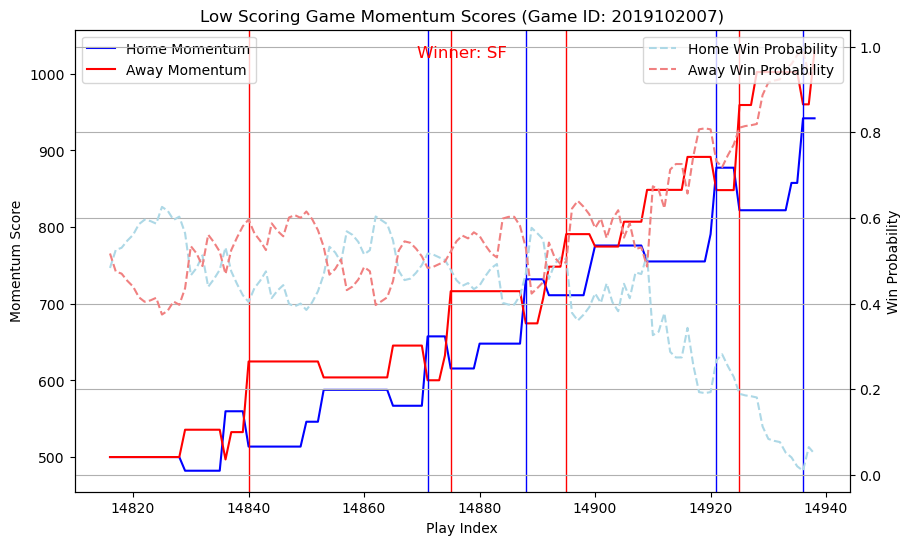

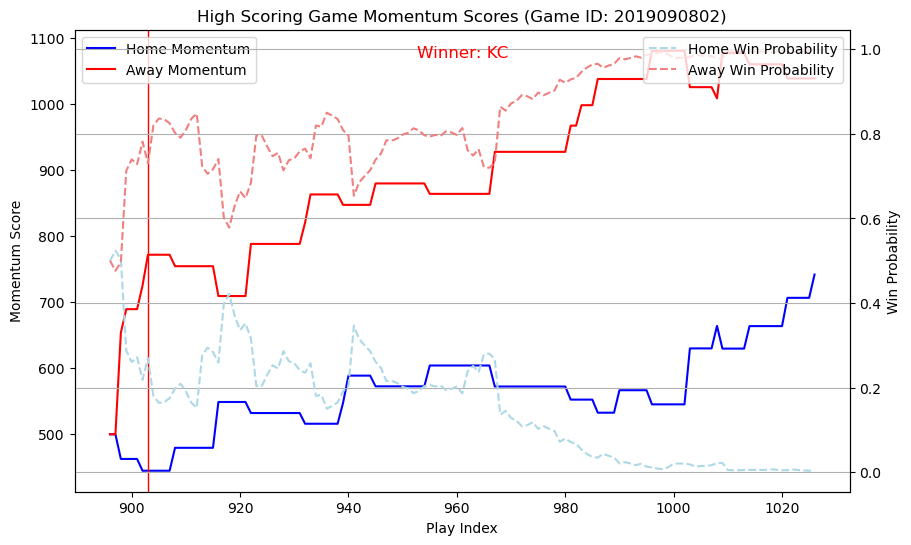

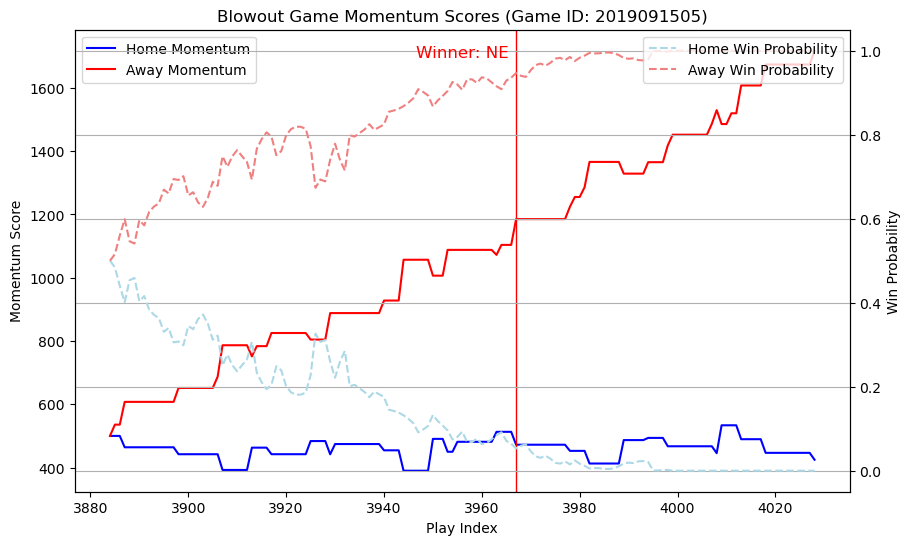

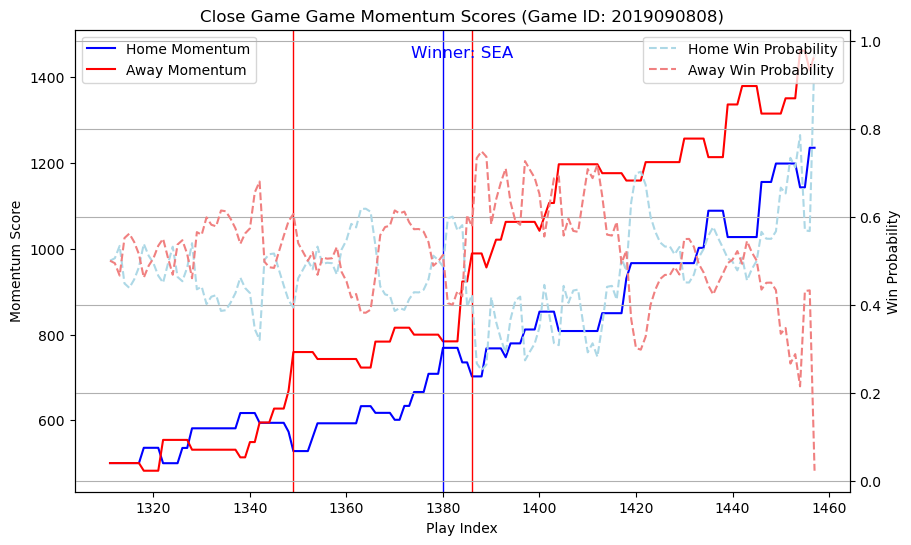

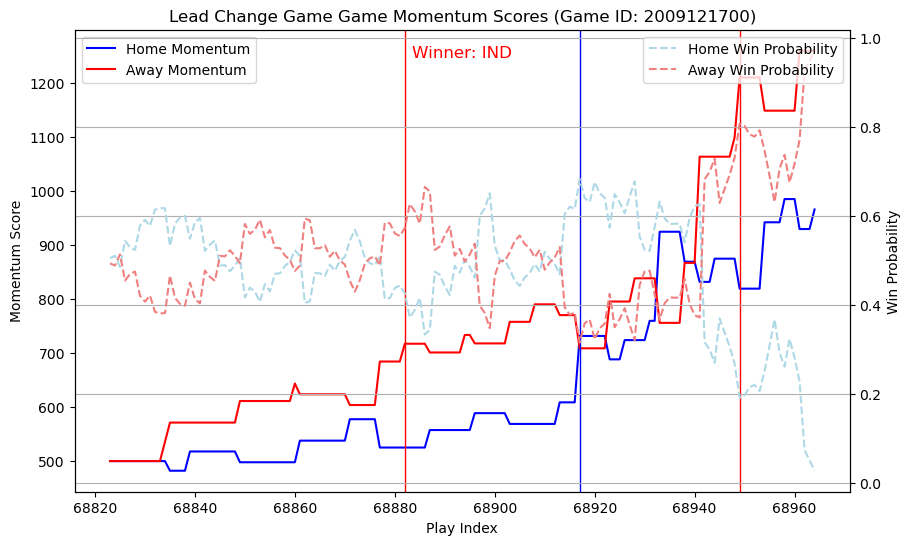

In [179]:
low_scoring_game_id = 2019102007  
high_scoring_game_id = 2019090802  
blowout_game_id = 2019091505     
close_game_id = 2019090808
lead_change_game_id = 2009121700 

low_scoring_game = dfV5[dfV5['game_id'] == low_scoring_game_id]
high_scoring_game = dfV5[dfV5['game_id'] == high_scoring_game_id]
blowout_game = dfV5[dfV5['game_id'] == blowout_game_id]
close_game = dfV5[dfV5['game_id'] == close_game_id]
lead_change_game = dfV5[dfV5['game_id'] == lead_change_game_id]

def plot_momentum_scores(game_data, game_id, game_type, home_score, away_score, home_team, away_team):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot Momentum Scores on the first y-axis (left)
    ax1.plot(game_data['Home_Momentum_Score'], label='Home Momentum', color='blue')
    ax1.plot(game_data['Away_Momentum_Score'], label='Away Momentum', color='red')
    
    ax1.set_xlabel('Play Index')
    ax1.set_ylabel('Momentum Score', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    
    # Create a second y-axis for Win Probabilities
    ax2 = ax1.twinx()
    ax2.plot(game_data['home_wp'], label='Home Win Probability', color='lightblue', linestyle='--')
    ax2.plot(game_data['away_wp'], label='Away Win Probability', color='lightcoral', linestyle='--')
    
    ax2.set_ylabel('Win Probability', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    
    # Determine the winner
    if home_score > away_score:
        winner = home_team
        winner_color = 'blue'  
    elif away_score > home_score:
        winner = away_team
        winner_color = 'red'   
    else:
        winner = "Draw"
        winner_color = 'gray'  
    
    # Add title
    plt.title(f'{game_type} Game Momentum Scores (Game ID: {game_id})')
    
    # Annotate winner
    plt.text(0.5, 0.95, f'Winner: {winner}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12, color=winner_color)


    # Highlight Momentum Shifts and set color based on Momentum Holding Team
    momentum_shifts = game_data[game_data['Momentum_Shift_Occurred'] == True].index
    for shift in momentum_shifts:
        # Check the team holding the momentum at that point
        holding_team = dfV5.at[shift, 'Momentum_Holding_Team']
        if holding_team == 'Home':
            ax1.axvline(x=shift, color='blue', linestyle='-', linewidth=1)  # Blue for Home
        elif holding_team == 'Away':
            ax1.axvline(x=shift, color='red', linestyle='-', linewidth=1)  # Red for Away

    # Legends for both axes
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.grid(True)
    plt.show()

# Plot for the selected games
final_game_rows = dfV5.groupby('game_id').tail(1)

plot_momentum_scores(low_scoring_game, low_scoring_game_id, 'Low Scoring',
                     final_game_rows.loc[final_game_rows['game_id'] == low_scoring_game_id, 'total_home_score'].iloc[0],
                     final_game_rows.loc[final_game_rows['game_id'] == low_scoring_game_id, 'total_away_score'].iloc[0],
                     low_scoring_game['home_team'].iloc[0], low_scoring_game['away_team'].iloc[0])

plot_momentum_scores(high_scoring_game, high_scoring_game_id, 'High Scoring',
                     final_game_rows.loc[final_game_rows['game_id'] == high_scoring_game_id, 'total_home_score'].iloc[0],
                     final_game_rows.loc[final_game_rows['game_id'] == high_scoring_game_id, 'total_away_score'].iloc[0],
                     high_scoring_game['home_team'].iloc[0], high_scoring_game['away_team'].iloc[0])

plot_momentum_scores(blowout_game, blowout_game_id, 'Blowout',
                     final_game_rows.loc[final_game_rows['game_id'] == blowout_game_id, 'total_home_score'].iloc[0],
                     final_game_rows.loc[final_game_rows['game_id'] == blowout_game_id, 'total_away_score'].iloc[0],
                     blowout_game['home_team'].iloc[0], blowout_game['away_team'].iloc[0])

plot_momentum_scores(close_game, close_game_id, 'Close Game',
                     final_game_rows.loc[final_game_rows['game_id'] == close_game_id, 'total_home_score'].iloc[0],
                     final_game_rows.loc[final_game_rows['game_id'] == close_game_id, 'total_away_score'].iloc[0],
                     close_game['home_team'].iloc[0], close_game['away_team'].iloc[0])

plot_momentum_scores(lead_change_game, lead_change_game_id, 'Lead Change Game',
                     final_game_rows.loc[final_game_rows['game_id'] == lead_change_game_id, 'total_home_score'].iloc[0],
                     final_game_rows.loc[final_game_rows['game_id'] == lead_change_game_id, 'total_away_score'].iloc[0],
                     lead_change_game['home_team'].iloc[0], lead_change_game['away_team'].iloc[0])

# Reminder: need to clean data and remove helper features no longer needed up to this point and remove momentum shift occuring at start of new game